<a href="https://colab.research.google.com/github/ThOpaque/HomeMade_FaceID/blob/dev_SiameseModel2/SiameseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Where should we start ?

What we are trying to do here is called *face verification*. I insist on the term *verification* since you will find a lot of misleading articles on the internet, were *recognition* and *verification* are used both to describe the same problem. \
Here, we are talking about *verification* that is, verified that a person is the expected person (*is it this person ?*). One refers to this type of problem as a 1:1 problem i.e. two faces are shown to the model and it should be able to assert if they belong to the same person or not. One can find this type of application on the Apple iPhone FaceID for instance with a "training phase" when you use it for the first time to specialized the algorithm with your face. Also, one can find this application in some airport where we are invited to present our passport to the AI so it can verify if we are indeed the person on the passport photo.

At the contrary, a *face recognition* problem is a 1:K problem : the model tries to find if a person is a member of its database. It involves a representative dataset for each member and a certain flexibility since we expect that the model should handle a new person whithout retraining it from scratch. One can find this type of application in some company entrence for instance.

Here, we are trying to unlock a computer with the administrator face. Since no one else will be authorized to unlock the session, it's a face verification 1:1 problem.

# What should the model do ?
Instinctively we know the model should authorized one specific person and rejects all different. To achive this, we'll use the technique of *one shot learning* with *Siamese Networks* which is a very efficient technique for face verification.

## Siamese Networks
The main principle behind Siamese Networks is to use the *same* model with the *same* parameters to classify two images. Two images are fed to networks that share parameters with the exact same structure (hence the model's name) and then, the raw outputs (called embeddings) are compared. In practice, this can be achieve by doing two forward passes with the same model *before* backpropagate and update the model parameters. With the appropriate loss function, the model will hopefully learn the similarity between the two images. 

[images siamese net]

## One Shot Learning
You'll find many articles about One Shot Learning on the internet but I am going to explain it briefly. 

One Shot Learning is the idea in which classification or categorization tasks can be achieved with one or a few examples to classify many new examples. Back to our problem, an image of the administrator will be given to the model (it's the *anchor*) and then, the model should be capable to classify any image regarding this anchor (this is the same person or it is not). 

Technically, the model will *encode* the image as an *embedding vector* of d-dimension (e.g. 128). That is, any embedding image will be place in a n-dimensional Euclidean space and will belong to a specific location such that (luckily) similar identities should be close to each others, and different identities will be found far apart.  

[images MNIST t-SNE]


This method is called *one shot learning* since it does not involve *a priori* any extra training when using another anchor. However, in the case of transfer learning, a few training steps are needed to converge to the right distribution i.e. to make the model understand the context (will it be net and clean image with good luminosity ? Does the luminosity may vary ? will it be webcam photos with poor quality ? etc...).


__Note__ : this adding training steps are needed either in the case of transfer learning (since one model is trained with various milion of images and then no particular distribution), or simply to improve the model's accuracy regarding the anchor in the case of face verification for example. 

# Loading librairies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
### Python modules
import os
import numpy as np
import glob
import random as rd
import pandas as pd
import pickle
import datetime

### PyTorch modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

%pip install torchinfo --quiet
from torchinfo import summary

### Preprocessing modules
from PIL import Image
import torchvision
import torchvision.transforms

### External module : FaceNet
%pip install facenet-pytorch --quiet
from facenet_pytorch import InceptionResnetV1, MTCNN

### Define the current device
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #for Colab GPU
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu') #for Mac M1 chips
print("\n------------------------------------")
print(f"Execute notebook on -{device}-")
print("------------------------------------\n")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

------------------------------------
Execute notebook on -mps-
------------------------------------



# Building the dataset

## How to structure the dataset ?
In this notebook, we'll use a pretrained model called FaceNet. Since this model has been trained on million person faces, it could already give us pretty good results. However, as mentionned earlier, it is wise to modify and train the last layers of the model to specialize it on the distribution of images that it might enconters (i.e. webcam images here).

So, we need a dataset class who retrives labeled images. That is, retrives images with an associated label where 1 is for "same person as the administrator" and 0 for "different person as the administrator". Those are respectively called *Positive* and *Negative* images. 

We create a `SiameseDataset` class which will be used to construct our training set. It is composed of 5 extra attributs required to completly define a class instance :

*   `PN_df` corresponds to a Pandas DataFrame containing same and different labelised administrator's faces (1 for same, 0 for different) ;
*   `val_stride` & `isValSet_bool` are used to separate the training set to the validation set and make sure that there is no data leaks between them ;
*   `isAugment_bool` is used to specify the kind of transformation applied to an image in order to diversify the distribution ;
*   `isNormalize_bool` is used to normalize the images by their own mean/std values.


In [26]:
class SiameseDataset(Dataset):
    def __init__(self, df:pd.DataFrame, val_stride:int=0, isValSet_bool:bool=None, isAugment_bool:bool=False, isNormalize_bool:bool=False)->tuple:
        
        self.isNormalize_bool = isNormalize_bool
        self.isAugment_bool = isAugment_bool
        self.PN_df = df

        if isValSet_bool:
            assert val_stride > 0, 'val_stride argument must be greater than 0'
            self.PN_df = self.PN_df[::val_stride]
            self.PN_df = self.PN_df.reset_index(drop=True)
        elif val_stride > 0:
            self.PN_df = self.PN_df.drop(self.PN_df.index[::val_stride])
            self.PN_df = self.PN_df.reset_index(drop=True)

    def _preprocess(self, img_t:torch.Tensor)->torch.Tensor:
        ### Resizing
        if type(img_t) is Image.Image:
            img_t = torchvision.transforms.ToTensor()(img_t)
        transform = torchvision.transforms.Compose([torchvision.transforms.Resize((160,160))])
        img_t = transform(img_t)

        ### Data augmentation
        if self.isAugment_bool:
            augment = torchvision.transforms.Compose([
                torchvision.transforms.RandomHorizontalFlip(p=0.5),
                torchvision.transforms.ColorJitter(brightness=[0.5,1], contrast=[1,1.2], saturation=[0,1]),
                torchvision.transforms.RandomAdjustSharpness(12, p=0.7),
                torchvision.transforms.RandomRotation(degrees=5)
                ])
            img_t = augment(img_t)
        
        ### Normalize data
        if self.isNormalize_bool:
            mean, std = img_t.mean(), img_t.std()
            img_t = (img_t - mean) / std

        return img_t

    def __len__(self):
        return self.PN_df.shape[0]
    
    def __getitem__(self, idx)->tuple:
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_t = self.PN_df['Images'][idx]
        image = self._preprocess(img_t)

        label = self.PN_df['Labels'][idx]
        
        return image, torch.tensor(label, dtype=torch.int32)


## Composition of the dataset
As mentioned earlier, we need "negative" faces for this project. I've decided to randomly select 500 images from the ["Labeled Faces in the Wild" database](http://vis-www.cs.umass.edu/lfw/) (note that I chose aligned faces with funneling). The positive images are photos of myself captured in such a way that various face positions are represented (I replaced my face by a cartoon face for the example). 

I may call positive images "*calibration images*" since they are used to calibrate the model to a specific distribution (i.e. specific context).

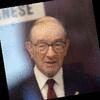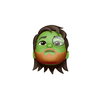



In [3]:
#main_path = "/content/drive/MyDrive/Colab Notebooks/face_verification"
main_path = "/Users/thierryksstentini/Downloads"

### Loading PIL images from lfw dataset
with open(main_path+'/dataset/dataset_augmented/lfw_PIL.pkl', 'rb') as pkl:
    PIL_imgs_notme = pickle.load(pkl)
PIL_imgs_notme = rd.sample(PIL_imgs_notme, 650)

### Loading paths of calibration images and converting to PIL images 
path_imgs_me_calibration = glob.glob(main_path+'/dataset/dataset_calibration2/*.jpg')
# path_imgs_me_calibration = glob.glob(main_path+'/dataset/dataset_moi_mbp_cropped/*.jpg')
PIL_imgs_me_calibration = [Image.open(k).convert('RGB') for k in path_imgs_me_calibration]

print(f"Set of PIL images that is not the administrator identity, lenght : {len(PIL_imgs_notme)}")
print("--------")
print(f"Set of calibration PIL images corresponding to the administrator identity, lenght : {len(PIL_imgs_me_calibration)}")
print("--------")

Set of PIL images that is not the administrator identity, lenght : 650
--------
Set of calibration PIL images corresponding to the administrator identity, lenght : 150
--------


## Cropping faces
The one-shot learning method is pretty capricious and one be carefull to compare faces with a minimum of background informations (and control the risk of cutting essential parts of a face such as hair, beard, ears...). Here, we implement a function which uses the [MTCNN module](https://arxiv.org/abs/1604.02878) for face detection. This module is really helpfull since it detects faces and returns bounding boxes using a cascaded framework (GitHub repo [here](https://github.com/timesler/facenet-pytorch) for MTCNN migration from TensorFlow to PyTorch).

In [ ]:
def detect_faces(PIL_imgs:list, device:torch.device)->list:
    """Preprocessing function that detects faces and returns a cropped PyTorch tensor.
    It also prevents various exceptions caused by face detection failure or
    misliding coordinates with negative values. 

    -------------------
    Parameters:
        PIL_imgs: list
            The list of PIL images to crop.
        device: torch.device. Default 'cpu'
            Basically cuda, mps or cpu.
    -------------------
    Returns:
        imgs_crop: list of torch.Tensor 
            List of the cropped images resized by (160x160).
    """
    imgs_crop = []
    count_TypeError = 0
    count_RuntimeError = 0

    for it, img in enumerate(PIL_imgs):
        try : 
            ### Get bounding boxes coordinates
            mtcnn = MTCNN(device=device)
            x1, y1, x2, y2 = mtcnn.detect(img)[0][0]

            ### Set to zero if coordinates are outside the frame
            x1, y1 = max(0, int(x1)), max(0, int(y1))
            x2, y2 = int(x2), int(y2)

            img_t = torchvision.transforms.ToTensor()(img).to(device)
            img_t = img_t[:,y1:y2, x1:x2]

        ### Raises an exception if no face is detected
        except TypeError:
            img_t = None
            count_TypeError += 1
        else :
            try :
                img_t = torchvision.transforms.Resize((160,160))(img_t)
                imgs_crop.append(img_t)
            except RuntimeError:
                count_RuntimeError += 1

        ############ Result display part #################
        if it == 0 or it%100==0 or it==len(PIL_imgs)-1:
            print(f"Iteration : {it+1}/{len(PIL_imgs)}")
    print(f"END : Got {len(imgs_crop)}/{len(PIL_imgs)} images.")
    print(f"Number of TypeError : {count_TypeError} \nNumber of RuntimeError : {count_RuntimeError}")
    return imgs_crop

In [ ]:
print('Cropping positive images')
PIL_imgs_me_crop_calibration = detect_faces(PIL_imgs_me_calibration, device)
print('---------------------')
print('\nCropping negative images')
PIL_imgs_notme_crop = detect_faces(PIL_imgs_notme, device)

## Building training and validation datasets
The calibration phase should be as quick as possible to provide a user friendly interaction with the app. This means that only a small amount of images should be recorded.\
In this example, I recorded 150 images of myself and it renders only 119 operable results after the cropping phase. 

To bypass this lack of data, I chose to augment my dataset by duplicate those 119 images 3 times and then, perform random shifting on image pixels (data augmentation). Doing so makes it possible to increase the positive image number and then reducing data unbalance (357 positives vs 500 negatives).

This step is handled by the `preprocess` method of the `SiameseDataset` class.

Note that a randomization is performed on the dataset *before* turning the database into a dataset (i.e. not in the `SiameseDataset` class). By doing so, it prevents data leaking when creating training and validation sets as instances of the `SiameseDataset` class.

In [ ]:
### Duplicate data
# PIL_imgs = PIL_imgs_me_crop_calibration + PIL_imgs_me_crop_calibration + PIL_imgs_me_crop_calibration + PIL_imgs_notme_crop

PIL_imgs_me_crop_calibration = PIL_imgs_me_calibration 
PIL_imgs_notme_crop = PIL_imgs_notme
PIL_imgs = PIL_imgs_me_calibration + PIL_imgs_notme

#PIL_imgs = [k.to('cpu') for k in PIL_imgs]

### Creating label vectors (1 for positive faces and 0 for negatives)
label_P = np.full(len(PIL_imgs_me_crop_calibration), 1)
label_N = np.full(len(PIL_imgs_notme_crop), 0)
labels = np.concatenate((label_P, label_N))

### Pandas DataFrame and randomization
df_PIL = pd.DataFrame({'Images':PIL_imgs, 'Labels':labels})
df_PIL = df_PIL.sample(frac=1).reset_index(drop=True)

len(PIL_imgs), len(df_PIL)

In [27]:
###################
### Loading pre-saved dataset
load = True
if load :
    main_path = "/Users/thierryksstentini/Downloads"
    with open(main_path + '/dataset/calibration_set_moi&pasmoi_len619_crop.pkl', 'rb') as pkl :
        df_PIL = pickle.load(pkl)
###################

## Creating sets

In [7]:
BATCH_SIZE = 128
siameseDataset_train = SiameseDataset(df=df_PIL, val_stride=4, isValSet_bool=False, isNormalize_bool=True, isAugment_bool=True)
siameseDataset_test = SiameseDataset(df=df_PIL, val_stride=4, isValSet_bool=True, isNormalize_bool=True, isAugment_bool=True) ### WARNING : avant on avait isAugment_bool = True !!


train_dataloader = DataLoader(siameseDataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(siameseDataset_test, batch_size=BATCH_SIZE, shuffle=True) ### Warning : avant = shuffle = True

len(siameseDataset_train), len(siameseDataset_test)

(464, 155)

# Creating a custom loss function

## Triplet mining & Batch-All Triplet Loss
The method used to compute the loss is "Batch-All triplets". I reuse a triplet mining method from the incredibly clever work of [Olivier Moindrot](https://https://omoindrot.github.io/triplet-loss) (see how he uses broadcasting) and basically rewrite it into a `nn.Module` PyTorch.

As explained earlier, the dataset is composed of positive and negative images so, a *triplet* will be composed of an *anchor image*, a *positive* and a *negative* one. This will be used to compute the so called *Triplet Loss* :

\begin{equation}
    L = max( \lVert{AP}\rVert - \lVert{AN}\rVert + \alpha, 0)
\end{equation}

With :

*   A, P, N -- respectively the anchor, positive and negative image embeddings
*   $\lVert{.}\rVert$ -- L2 norm
*   $\alpha$ -- a margin

When minimizing this loss, $\lVert{AP}\rVert$ is pushed towards 0 and $\lVert{AN}\rVert$ grows to be greater than $\lVert{AP}\rVert+\alpha$. When $N$ is an "easy negative" (i.e. obvious wrong face), the loss is zero.

From [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/abs/1703.07737), [Olivier Moindrot](https://omoindrot.github.io/triplet-loss) explains the following about triplet mining :


> Based on the definition of the loss, there are three categories of triplets:

> * __Easy triplets__: triplets which have a loss of 0, because $\lVert{AP}\rVert+\alpha < \lVert{AN}\rVert$

> * __Hard triplets__: triplets where the negative is closer to the anchor than the positive, i.e. $\lVert{AN}\rVert < \lVert{AP}\rVert$

> * __Semi-hard triplets__: triplets where the negative is not closer to the anchor than the positive, but still have positive loss : $\lVert{AP}\rVert < \lVert{AN}\rVert < \lVert{AN}\rVert+\alpha$

> *Each of these definitions depend on where the negative is, relatively to the anchor and positive. We can therefore extend these three categories to the negatives : __hard negatives__, __semi-hard negatives__ or __easy negatives__.*

The "Batch-All Triplet" method will find all valid triplets in a batch : regarding all the positives, we select an anchor and construct a *valid* triplet (i,j,k) such as;
* i, j and k must be distinct
* label[i] equals label[j] (find a positive)
* labels[i] differents from label[k] (find a negative)

Then, *only those valid triplets* will feed the model.

An other method of mining is the "Batch Hard" : for each anchor, we select the hardest positive (biggest distance A-P) and the hardest negative among the batch. 

According to the [paper](https://arxiv.org/abs/1703.07737), the batch hard strategy yields to the best performance. However it really depends on the dataset and a Batch-All method is chosen here for simplicity.

In [8]:
class BatchAllTripletLoss(nn.Module):
    def __init__(self, margin:float, device:torch.device):
        """Compute the Batch All triplet loss method."""
        super(BatchAllTripletLoss, self).__init__()        
        self.margin = margin
        self.device = device

    def _pairwise_distances(self, embeddings:torch.Tensor)->torch.Tensor:  
        """Compute the 2D matrix of distances between all the embeddings.

        -------------------
        Parameters:
            embeddings: torch.Tensor of shape (batch_size, embed_dim)
        -------------------
        Returns:
            imgs_crop: torch.Tensor of shape (batch_size, batch_size)
        """
        embeddings = embeddings.to(torch.float)
        distances = torch.cdist(embeddings, embeddings, p=2)
        return distances

    def _get_triplet_mask(self, labels:torch.Tensor)->torch.Tensor:
        """Return a 3D mask where mask[a, p, n] is True if the triplet (a, p, n) is valid.
        A triplet (i, j, k) is valid if:
            - i, j, k are distinct
            - labels[i] == labels[j] and labels[i] != labels[k]

        -------------------
        Parameters:
            labels: torch.int32 of shape (batch_size,)
        -------------------
        Returns:
            mask: torch.Tensor of shape (batch_size, batch_size, batch_size)
        """
        # Check that i, j and k are distinct
        indices_equal = torch.eye(labels.shape[0]).to(torch.bool).to(self.device)
        indices_not_equal = torch.logical_not(indices_equal)
        i_not_equal_j = indices_not_equal.unsqueeze(2)
        i_not_equal_k = indices_not_equal.unsqueeze(1)
        j_not_equal_k = indices_not_equal.unsqueeze(0)

        distinct_indices = torch.logical_and(torch.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)

        # Check if labels[i] == labels[j] and labels[i] != labels[k]
        label_equal = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))
        i_equal_j = label_equal.unsqueeze(2)
        i_equal_k = label_equal.unsqueeze(1)

        valid_labels = torch.logical_and(i_equal_j, torch.logical_not(i_equal_k))

        # Combine the two masks
        mask = torch.logical_and(distinct_indices, valid_labels)
        return mask

    def forward(self, embeddings_pred:torch.Tensor, labels_target:torch.Tensor):
        """Forward method of the class. Build the triplet loss over a batch of 
        embeddings. All the valid triplets are generated and the loss is averaged 
        over the positive ones.

        -------------------
        Parameters:
            labels: torch.Tensor of shape (batch_size,)
                Labels of the batch
            embeddings: torch.Tensor of shape (batch_size, embed_dim)
                Embeddings of the batch
        -------------------
        Returns:
            triplet_loss: torch.float, scalar 
                Contains the triplet loss of the batch
            fraction_positive_triplets: flot, scalar
                Contains the ratio of positive triplets in the batch
        """
        # Get the pairwise distance matrix
        pairwise_dist = self._pairwise_distances(embeddings_pred)

        # shape (batch_size, batch_size, 1)
        anchor_positive_dist = pairwise_dist.unsqueeze(2)
        assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
        # shape (batch_size, 1, batch_size)
        anchor_negative_dist = pairwise_dist.unsqueeze(1)
        assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

        # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
        triplet_loss = anchor_positive_dist - anchor_negative_dist + self.margin

        # Put to zero the invalid triplets
        # (where label(a) != label(p) or label(n) == label(a) or a == p)
        mask = self._get_triplet_mask(labels_target).to(torch.float)
        triplet_loss = torch.multiply(mask, triplet_loss)

        # Remove negative losses (i.e. the easy triplets)
        triplet_loss = torch.maximum(triplet_loss, torch.tensor(0.0))
        
        # Count number of positive triplets (where triplet_loss > 0)
        valid_triplets = torch.gt(triplet_loss, 1e-16).to(torch.float)
        num_positive_triplets = torch.sum(valid_triplets)
        num_valid_triplets = torch.sum(mask)
        fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

        # Get final mean triplet loss over the positive valid triplets
        triplet_loss = torch.sum(triplet_loss) / (num_positive_triplets + 1e-16)

        return triplet_loss, fraction_positive_triplets

# Building the model
We are using a version of the FaceNet model described in this [paper](https://arxiv.org/abs/1503.03832). It's an Inception ResNet model, pretrained on VGGFace2 and CASIA-Webface. The Tim Esler's [implementation](https://github.com/timesler/facenet-pytorch) in PyTorch is used, where the model weights were initialized using parameters ported from David Sandberg's [work](https://github.com/davidsandberg/facenet).

The model can be used for classification (face recognition) or not. In the later case, it outputs a *normalized embedding* of (512,1) dimension.

## Customizing the model
For the purpuse of this work, several tries led me to modify the top layers of the model. In the litterature, outputting a (128,1) normalized vector seems to be a good start. So, I kept the whole `InceptionResnetV1` pretrained model, got rid of the last **batch norm** and **linear** layers and add a **smooth** dimensional decrease with linear layers until a **(128,1) normalized output** vector.

**Note** : in one-shot learning, it's a common way to compare L2-normalized embeddings.

In [15]:
class SiameseNet(nn.Module):
    def __init__(self):
        """Custom the FaceNet InceptionResnetV1 model.
        """
        super(SiameseNet, self).__init__()
        self.FaceNetModif_seq1 = nn.Sequential(*list(InceptionResnetV1(pretrained='casia-webface').children())[:-3])
        self.FaceNetModif_seq2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1792, 512, bias=True),
            nn.Linear(512, 256, bias=True),
            nn.Linear(256,128, bias=True),
            #nn.Linear(1792, 128, bias=True),
            nn.BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True)
        )
    def forward(self, input:torch.Tensor)->torch.Tensor:
        """Forward method of the model.

        -------------------
        Parameters:
            x: torch.Tensor of shape (batch_size, channels, height, width)
                Batch of the tensor images
        -------------------
        Returns:
            x: torch.Tensor of shape (batch_size, 128)
                Batch of embeddings as the predictions of the model
        """
        x = self.FaceNetModif_seq1(input)
        x = self.FaceNetModif_seq2(x)
        return x

## Using pretrained model & optimization
As explained above, we use a pretrained model on the [VGGFace2](https://arxiv.org/abs/1710.08092) database which is consistent with our goal here. Only the added linear layers are not freezed to train them on the administrator's face dataset. 

Adam optimization is used with a learning rate `lr=0.005`. The number of epochs is defined regarding previous training sessions as `num_epochs = 50`.

In [19]:
device = 'cpu'

### Creating the model and cast to device
model_custom = SiameseNet().to(device)

### Freezing all pretrained layers
for param in model_custom.FaceNetModif_seq1.parameters():
    param.requires_grad = False

margin = 0.1
triplet_loss = BatchAllTripletLoss(margin=margin, device=device)
optimizer = torch.optim.Adam(model_custom.parameters(), lr=0.005)
num_epochs = 25

# Training loop
Note : the margin $\alpha$ `margin = 0.1` is set regarding previous training sessions. 


In [13]:
anchor_base = Image.open('/Users/thierryksstentini/Downloads/dataset/anchors/frame_base_cropped.jpeg').convert('RGB')
anchor_base = torchvision.transforms.ToTensor()(anchor_base)
anchor_base = torchvision.transforms.Resize((160,160))(anchor_base)
def Normalize(img_t):
    mean, std = img_t.mean(), img_t.std()
    img_t = (img_t - mean) / std
    return img_t

anchor_base = Normalize(anchor_base)

In [17]:
imgs.shape

torch.Size([128, 3, 160, 160])

In [ ]:


delta_time = datetime.timedelta(hours=1)
timezone = datetime.timezone(offset=delta_time)
#/Users/thierryksstentini/Downloads/dataset/anchors/frame_base_cropped.jpeg

threshold = 0.5
size_train = len(siameseDataset_train)
ranger = range(num_epochs)

#### For restart only ###########################
RESTART = False

if not RESTART :
    train_loss_list = []
else :
    new_start = epoch+1
    new_end = new_start + 20
    ranger = range(new_start, new_end)
    print(f"[RESTART AT] : epoch = {new_start}\n")
    print("-------------------------------")
###################################################



#### Start time infos #############################
t = datetime.datetime.now(tz=timezone)
str_t = '{:%Y-%m-%d %H:%M:%S}'.format(t)
print(f"[START] : {str_t} :")
print(f"[Training on] : {str(device).upper()}")
print(f"[Optimizer] : \n{optimizer}")
print("-------------------------------")
###################################################



for epoch in ranger:
    t = datetime.datetime.now(tz=timezone)
    str_t = '{:%Y-%m-%d %H:%M:%S}'.format(t)
    print(f"{str_t} : Epoch {epoch+1} \n-------------------------------")
    
    train_loss = 0.0
    train_accuracy = 0
    for batch, (imgs, labels) in enumerate(train_dataloader):
        model_custom.train()
        lenimgs = len(imgs)

        # Transfer Data to GPU if available
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Clear the gradients
        optimizer.zero_grad()

        # Make prediction 
        preds_embeddings = model_custom(imgs)
        
        # Compute the training loss with BatchAllTripletLoss method
        loss, fraction_positive_triplets = triplet_loss(preds_embeddings, labels)        

        # Compute the gradients
        loss.backward()

        # Update Weights
        optimizer.step()

        # Aggregate mini-batch training losses
        train_loss += loss.item()
        train_loss_list.append(train_loss)



        count_P = 0
        model_custom.eval()
        with torch.no_grad():
            anchor = anchor_base.unsqueeze(0).to(device)
            anchor_emb = model_custom(anchor)
        
            for it in range(len(preds_embeddings)):
                d1 = np.linalg.norm(anchor_emb.to('cpu') - preds_embeddings[it].to('cpu'))
                label = labels[it]

                if label == 1 and d1 < threshold:
                    count_P += 1
            acc = (count_P/BATCH_SIZE)*100

        ### Print status #######################################################
        if batch==0 or batch%(size_train//BATCH_SIZE):
            loss_item = loss.item()
            current = batch*BATCH_SIZE + lenimgs
            print(f"mini-batch loss for training : {loss_item:>7f}  [{current:>5d}/{size_train:>5d}]")
            print(f"Fraction positive triplet in this batch : {fraction_positive_triplets*100:.3f}")
            print(f"Train accuracy : {acc}%")


    
    # Compute the global training & validation loss as the mean of the mini-batch losses
    train_loss /= len(train_dataloader)
    print(f"--Fin Epoch {epoch+1}/{len(ranger)} \n Training Loss: {train_loss:>7f}" )
    print('\n')

In [ ]:
file_name = 'SiameseNet_calibrated2_12032022.pth'
torch.save(model_custom.state_dict(), '/content/drive/MyDrive/Colab Notebooks/face_verification/model_pth/' + file_name)

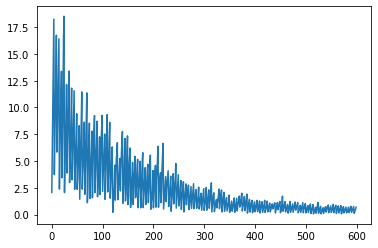

In [ ]:
loss_series = pd.Series(train_loss_list)
loss_series.plot()

#Evaluate the model

In [50]:
model_custom = SiameseNet()

In [51]:
#model_custom.state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/face_verification/model_pth/SiameseNet_calibrated2_12032022.pth', map_location='cpu')
model_custom.state_dict = torch.load(main_path + '/dataset/model_pth/SiameseNet_calibrated2_12032022.pth', map_location='cpu')

model_custom.eval();

In [126]:
anchor_base = Image.open('/Users/thierryksstentini/Downloads/dataset/anchors/moi_ok.jpg').convert('RGB')
anchor_base = torchvision.transforms.ToTensor()(anchor_base)
anchor_base = torchvision.transforms.Resize((160,160))(anchor_base)
def Normalize(img_t):
    mean, std = img_t.mean(), img_t.std()
    img_t = (img_t - mean) / std
    return img_t

anchor_base = Normalize(anchor_base)

In [127]:
threshold = 0.63

count_TP = 0
count_TN = 0
count_FP = 0
count_FN = 0
count_P = 0
count_N = 0

d_FP = []
d_FN = []


model_custom = model_custom.to(device)
for batch, (imgs, labels) in enumerate(train_dataloader):
    imgs = imgs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        anchor = anchor_base.unsqueeze(0).to(device)
        anchor_emb = model_custom(anchor)
        preds_embeddings = model_custom(imgs)

        for it in range(len(preds_embeddings)):
            d1 = np.linalg.norm(anchor_emb.to('cpu') - preds_embeddings[it].to('cpu'))
            labels = labels.to('cpu')
            if labels[it] == 1 and d1 < threshold:
                count_P += 1
                count_TP +=1
            if labels[it] == 1 and  d1 >= threshold:
                count_P += 1
                count_FN += 1
                d_FN.append(d1)

            if labels[it] == 0 and d1 >= threshold:
                count_N += 1
                count_TN += 1
            if labels[it] == 0 and d1 < threshold :
                count_N += 1
                count_FP += 1
                d_FP.append(d1)

    acc = (count_P/len(preds_embeddings))*100

    ### Print status #######################################################
    if batch==0 or batch%(size_train//BATCH_SIZE):
        print(f"Train accuracy : {acc}%")

Train accuracy : 15.625%
Train accuracy : 37.5%
Train accuracy : 55.46875%


In [128]:
print(f"Stats on VGG without norm with threshold : {threshold}")
print(f"Nb positive : {count_P}")
print(f"Nb Negative : {count_N}")
print(f"TP : {count_TP/count_P *100:3.2f}%")
print(f"TN : {count_TN/count_N *100:3.2f}%")
print(f"FN : {count_FN/(count_P) * 100:3.2f}%")
print(f"FP : {count_FP/(count_N) * 100:3.2f}%")
print(f"The model accuracy is {(count_TP+count_TN)/(count_P+count_N) * 100:3.2f}%")

Stats on VGG without norm with threshold : 0.63
Nb positive : 86
Nb Negative : 378
TP : 59.30%
TN : 85.19%
FN : 40.70%
FP : 14.81%
The model accuracy is 80.39%


In [28]:
def encoder(input, model:SiameseNet, device:torch.device, isCrop:bool=False, 
            doNormalize:bool=False, isPIL:bool=False)->torch.Tensor:
    """Encode an input image to an embedding of shape (128,1) using the trained 
    model.

    -------------------
    Parameters:
        input: PIL.image, str or torch.Tensor
            Input to encode into embeddings.
        model: SiameseNet
            Custo trained model based on the IncecptionResnetV1 model.
        device: torch.device
            The device on which to run matrice computations.
        isCrop: bool, optionnal
            Is the image cropped ?. Default is False.
            If isCrop=True, the input should be a torch.Tensor already cropped.
        doNormalize: bool, optionnal
            Determines if the function must normalize the image or not. Default is False.
        isPIL: bool, optionnal
            Is the input a PIL image (True) ? Or a path (False) ?. Default is False.
    -------------------
    Returns:
        embedding: torch.Tensor of shape (128,1)
            Embedding of the input i.e. the encoding vector regarding the trained model.
    """
    if not isCrop:
        detector = MTCNN(device = device)
        if isPIL is False:
            PIL = Image.open(input).convert('RGB')
        else:
            PIL = input

        x1, y1, x2, y2 = detector.detect(PIL)[0][0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        img_t = torchvision.transforms.ToTensor()(PIL).to(device)
        img_t = img_t[:,y1:y2, x1:x2]
        img_t = torchvision.transforms.Resize((160,160))(img_t)
    else : 
        img_t = input

    if doNormalize:
        mean, std = img_t.mean(), img_t.std()
        img_t = (img_t - mean) / std

    img_t = img_t.unsqueeze(0)
    
    model.to(device)
    model.eval()
    with torch.no_grad():
        embedding = model(img_t)
    return embedding

In [ ]:
#anchor_path = '/content/drive/MyDrive/Colab Notebooks/face_verification/dataset/anchors/frame_base.jpg'
anchor_path = '/Users/thierryksstentini/Downloads/dataset/anchors/frame_base.jpg'
anch_embedding = encoder(anchor_path, model_custom, device, isCrop=False, doNormalize=True, isPIL=False)
anch_embedding = anch_embedding.to('cpu')
#with open('/content/drive/MyDrive/Colab Notebooks/face_verification/pickle/anchor_base.pkl', 'wb') as anchor:
#    pickle.dump(anch_embedding, anchor)

In [ ]:
from scipy.spatial import distance
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#anchor_path = '/content/drive/MyDrive/Colab Notebooks/face_verification/dataset/random_imgs/moi_ok.jpg'
anchor_path = '/content/drive/MyDrive/Colab Notebooks/face_verification/dataset/anchors/frame_base.jpg'
anch_embedding = encoder(anchor_path, model_custom, device, isCrop=False, doNormalize=True, isPIL=False)

threshold = 0.5

count_TP = 0
count_TN = 0
count_FP = 0
count_FN = 0
count_P = 0
count_N = 0

imgs_FP = []
d_FP = []
imgs_FN = []
d_FN = []

dict_stat = {'Description' : {'Model':'InceptionResnetV1 + cutom layers output128',
                              'Biases' : True,
                              'trainset':'CasiaWebface + calibration_images_crop',
                              'margin':0.1,
                              'threshold':threshold,
                              'testset':'imgs_sven_crop',
                              'Normalized' : False
                              },
             'Stats global':{}
             }

it = 0
dataset = siameseDataset_test
for it in range(len(dataset)):
    img, label = dataset[it]
    img, label = img.to(device), label.to(device)
    
    try : 
        embedding = encoder(img, model_custom, device, doNormalize=True, isCrop=True, isPIL=True)
    except TypeError:
        pass
    except RuntimeError:
        pass

    d1 = np.linalg.norm(anch_embedding.to('cpu') - embedding.to('cpu'))

    if label == 1 and d1 < threshold:
        count_P += 1
        count_TP +=1
    elif label == 1 and  d1 >= threshold:
        count_P += 1
        count_FN += 1
        imgs_FN.append(img)
        d_FN.append(d1)

    if label == 0 and d1 >= threshold:
        count_N += 1
        count_TN += 1
    elif label == 0 and d1 < threshold :
        count_N += 1
        count_FP += 1
        imgs_FP.append(img)
        d_FP.append(d1)


    if it==0 or it%100 == 0 or it == len(dataset)-1:
        print(f"Image : {count_P+count_N}/{len(dataset)}")



dict_stat['Stats global'] = {
    'Nb_pos' : count_P,
    'Nb_neg' : count_N,
    'TP' : f'{count_TP/count_P *100:3.2f}%',
    'TN' : f'{count_TN/count_N *100:3.2f}%',
    'FN' : f'{count_FN/(count_P)*100:3.2f}%',
    'FP' :  f'{count_FP/(count_N)*100:3.2f}%',
    'accuracy' : f'{(count_TP+count_TN)/(count_P+count_N) * 100:3.2f}%'
}

Image : 1/214
Image : 101/214
Image : 201/214
Image : 214/214


In [ ]:
print(f"Stats on VGG without norm with threshold : {threshold}")
print(f"Nb positive : {count_P}")
print(f"Nb Negative : {count_N}")
print(f"TP : {count_TP/count_P *100:3.2f}%")
print(f"TN : {count_TN/count_N *100:3.2f}%")
print(f"FN : {count_FN/(count_P) * 100:3.2f}%")
print(f"FP : {count_FP/(count_N) * 100:3.2f}%")
print(f"The model accuracy is {(count_TP+count_TN)/(count_P+count_N) * 100:3.2f}%")

Stats on VGG without norm with threshold : 0.52
Nb positive : 88
Nb Negative : 126
TP : 98.86%
TN : 99.21%
FN : 1.14%
FP : 0.79%
The model accuracy is 99.07%


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/face_verification/dataset/dataset_PIL.pkl', 'rb') as file:
    testData = pickle.load(file)
testData.keys()

dict_keys(['dataset_moi_crop', 'dataset_paulinesven_crop', 'dataset_final_moi_crop', 'dataset_final_pasmoi_crop'])

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/face_verification/dataset/dataset_augmented/lfw_PIL.pkl', 'rb') as file:
    lfwData = pickle.load(file)
lfwData_select = rd.sample(lfwData, 1000)

In [ ]:
liste_test = testData['dataset_moi_crop'] + testData['dataset_paulinesven_crop'] + lfwData_select
label_p = np.full(len(testData['dataset_moi_crop']), 1)
label_n = np.full(len(testData['dataset_paulinesven_crop'] + lfwData_select), 0)
labels = np.concatenate((label_p, label_n))
len(liste_test), len(label_p), len(label_n), len(labels)

(2418, 1037, 1381, 2418)

In [ ]:
list_test_t = []
labels_test = []
liste_test = glob.glob('/content/drive/MyDrive/Colab Notebooks/face_verification/dataset/dataset_calibration3/*')
labels = np.full(len(liste_test),1)
for it in range(len(liste_test)):
    try : 
        img = encoder(liste_test[it], model_custom, device, doNormalize = True, isCrop=False, isPIL=False)
        labels_test.append(labels[it])
        list_test_t.append(img)
    except TypeError:
        pass
    except RuntimeError:
        pass
    if it%5==0:
        print(f"Image : {it}")
len(list_test_t), len(labels_test)

Image : 0
Image : 5
Image : 10
Image : 15


(20, 20)

In [ ]:
from scipy.spatial import distance
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#anchor_path = '/content/drive/MyDrive/Colab Notebooks/face_verification/dataset/random_imgs/moi_ok.jpg'
anchor_path = '/content/drive/MyDrive/Colab Notebooks/face_verification/dataset/anchors/frame_base.jpg'
anch_embedding = encoder(anchor_path, model_custom, device, isCrop=False, doNormalize=True, isPIL=False)

threshold = 0.5

count_TP = 0
count_TN = 0
count_FP = 0
count_FN = 0
count_P = 0
count_N = 0

imgs_FP = []
d_FP = []
imgs_FN = []
d_FN = []

dict_stat = {'Description' : {'Model':'InceptionResnetV1 + cutom layers output128',
                              'Biases' : True,
                              'trainset':'CasiaWebface + calibration2_images_crop',
                              'margin':0.1,
                              'threshold on validation set':threshold,
                              'Anchor' : 'frame_44',
                              'valset' : 'train/validation split = 214imgs',
                              'testset':'imgs_sven_crop',
                              'Normalized trainset' : True,
                              'Normalized valset' : True,
                              'Normalized testset' : True,
                              'Normalized anchor' : True,
                              },
             'Stats global':{}
             }

it = 0
dataset = list_test_t
for it in range(len(dataset)):
    img, label = dataset[it], torch.tensor(labels_test[it])
    img, label = img.to(device), label.to(device)
    embedding = list_test_t[it]
    d1 = np.linalg.norm(anch_embedding.to('cpu') - embedding.to('cpu'))

    if label == 1 and d1 < threshold:
        count_P += 1
        count_TP +=1
    elif label == 1 and  d1 >= threshold:
        count_P += 1
        count_FN += 1
        imgs_FN.append(img)
        d_FN.append(d1)

    if label == 0 and d1 >= threshold:
        count_N += 1
        count_TN += 1
    elif label == 0 and d1 < threshold :
        count_N += 1
        count_FP += 1
        imgs_FP.append(img)
        d_FP.append(d1)


    if it==0 or it%500 == 0 or it == len(dataset)-1:
        print(f"Image : {count_P+count_N}/{len(dataset)}")



dict_stat['Stats global'] = {
    'Nb_pos' : count_P,
    'Nb_neg' : count_N,
    'TP' : f'{count_TP/count_P *100:3.2f}%',
    #'TN' : f'{count_TN/count_N *100:3.2f}%',
    'FN' : f'{count_FN/(count_P)*100:3.2f}%',
    #'FP' :  f'{count_FP/(count_N)*100:3.2f}%',
    'accuracy' : f'{(count_TP+count_TN)/(count_P+count_N) * 100:3.2f}%'
}

Image : 1/20
Image : 20/20


In [ ]:
print(f"Stats on VGG without norm with threshold : {threshold}")
print(f"Nb positive : {count_P}")
print(f"Nb Negative : {count_N}")
print(f"TP : {count_TP/count_P *100:3.2f}%")
#print(f"TN : {count_TN/count_N *100:3.2f}%")
print(f"FN : {count_FN/(count_P) * 100:3.2f}%")
#print(f"FP : {count_FP/(count_N) * 100:3.2f}%")
print(f"The model accuracy is {(count_TP+count_TN)/(count_P+count_N) * 100:3.2f}%")

Stats on VGG without norm with threshold : 0.5
Nb positive : 20
Nb Negative : 0
TP : 100.00%
FN : 0.00%
The model accuracy is 100.00%


In [ ]:
save = False
file_name = 'stats_sur_imgsCalibration2_test_sur_imgsven_12032022.pkl'
if save : 
    with open('/content/drive/MyDrive/Colab Notebooks/face_verification/pickle/'+file_name, 'wb') as pkl:
        pickle.dump(dict_stat, pkl)
else : 
    with open('/content/drive/MyDrive/Colab Notebooks/face_verification/pickle/'+file_name, 'rb') as pkl:
        dict_stat = pickle.load(pkl)

In [ ]:
import pprint
pprint.pprint(dict_stat)

{'Description': {'Anchor': 'frame_44',
                 'Biases': True,
                 'Model': 'InceptionResnetV1 + cutom layers output128',
                 'Normalized anchor': True,
                 'Normalized testset': True,
                 'Normalized trainset': True,
                 'Normalized valset': True,
                 'margin': 0.1,
                 'testset': 'imgs_sven_crop',
                 'threshold on validation set': 0.5,
                 'trainset': 'CasiaWebface + calibration2_images_crop',
                 'valset': 'train/validation split = 214imgs'},
 'Stats global': {'FN': '5.71%',
                  'FP': '1.03%',
                  'Nb_neg': 1354,
                  'Nb_pos': 928,
                  'TN': '98.97%',
                  'TP': '94.29%',
                  'accuracy': '97.06%'}}
